### Installing Qiskit

#### Normal installation

In [1]:
%pip install qiskit[visualization] qiskit-ibm-runtime qiskit qiskit_aer python-dotenv

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


#### GPU installation

In [2]:
# %pip install qiskit[visualization] qiskit-ibm-runtime qiskit qiskit_aer-gpu python-dotenv

### Libraries Importing


In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from dotenv import load_dotenv
from sympy import *
import json
import time
import os

load_dotenv()
init_printing()
simulation_time = time.time()  # to calculate simulation time

In [3]:
backend = AerSimulator(method="statevector")
print(backend.available_devices())

('CPU',)


#### Use GPU

In [3]:
# backend.set_options(device="GPU")

#### Use real quantum

In [5]:
services = []
current_token = 0
for i in range(1, 6):
    print(i)
    services.append(QiskitRuntimeService(
        channel="ibm_quantum", token=os.getenv(f"TOKEN{i}")))
    

backend = services[current_token].backend("ibm_osaka") # for real quantum
# backend = services[0].backend("ibm_kyoto") # for real quantum

1
2
3
4
5



### Problem Definition

In [6]:
conf = json.load(open("../conf_6.json", "r"))

In [7]:
N = conf["N"]  # Number of Teachers
M = conf["M"]  # Number of Classes
H = conf["H"]  # Number of hours in week

required_qubits = (M * N * H) + (M * H) + (N * H)
iterations = 0

random_seed = conf["random_seed"]
shots = conf["shots"] * 5
layers = 5

print("Requried Qubits: ", required_qubits)

Requried Qubits:  6


In [8]:
# T_i is binary string denoting the available hours for each i Teacher
# C_j is binary string denoting the available hours for each j Class

T = conf["T"]
C = conf["C"]

R = conf["R"]  # R_ij must be either 0 or 1

terms_count = 0
equations = []

### Formulation

#### Equations

In [9]:
for i in range(1, N + 1):
  for j in range(1, M + 1):
    temp = total = 0
    for h in range(1, H + 1):
      temp += symbols(f"f_{i}{j}{h}")
    total += (temp - R[i-1][j-1])**2
    terms_count += len(total.expand().args)
    equations.append(total.expand())
equations

In [10]:
for j in range(1, M + 1):
  for h in range(1, H + 1):
    temp = total = 0
    for i in range(1, N + 1):
      temp += symbols(f"f_{i}{j}{h}")
    total += (temp + symbols(f"τ_{j}{h}") - 1)**2
    terms_count += len(total.expand().args)
    equations.append(total.expand())
equations

In [11]:
for i in range(1, N + 1):
  for h in range(1, H + 1):
    temp = total = 0
    for j in range(1, M + 1):
      temp += symbols(f"f_{i}{j}{h}")
    total += (temp + symbols(f"λ_{i}{h}") - 1)**2
    terms_count += len(total.expand().args)
    equations.append(total.expand())
equations

#### Decodeing Equations

In [12]:
def args(equation):
  return Add.make_args(equation)

def prepare_equation(term):
  theta = 1
  terms = []
  if type(term) == Mul:
    for i in term.args:
      if i.is_Integer:
        theta = i
      else:
        terms.append(i)
  else:
    terms.append(term.args[0]) 

  return [theta, decode(terms)]

def decode(terms):
  output = []

  for term in terms:

    term = str(term)

    if term.startswith("τ"):
      j = int(term[2])
      h = int(term[3])
      output.append((h-1) * M + (j - 1))


    elif term.startswith("λ"):
      i = int(term[2])
      h = int(term[3])
      output.append((H * M) + ((h-1) * N + (i - 1)))

    elif term.startswith("f"):
      i = int(term[2])
      j = int(term[3])
      h = int(term[4])
      output.append((H * M) + (N * H) + ((i - 1) * H * M) + ((j - 1) * H) + (h - 1))

  return output


In [13]:
prepared_equations = []
for equation in equations:
    temp = []
    for term in args(equation):
        if len(term.args) != 0:
            temp.append(prepare_equation(term))
    prepared_equations.append(temp)

prepared_equations

### Implementation

#### Objective Function

In [14]:
def f(i, j, h):
  return int(T[i-1][h-1] == C[j-1][h-1] == '1')

def tau_value(bit_string, j, h):
  return int(bit_string[(h-1) * M + (j - 1)])

def lambda_value(bit_string, i, h):
  return int(bit_string[(H * M) + ((h-1) * N + (i - 1))])

def f_value(bit_string, i, j, h):
  return int(bit_string[(H * M) + (N * H) + ((i - 1) * H * M) + ((j - 1) * H) + (h - 1)])

In [15]:
def objective(bit_string):
  # since qiskit represent solution in least significant bit format
  bit_string = bit_string[::-1]
  cost = 0
  a = b = c = d = 0
  # equation a
  for i in range(1, N + 1):
      for j in range(1, M + 1):
          for h in range(1, H + 1):
              if f(i, j, h) != f_value(bit_string, i, j, h):
                  cost += 1
                  a += 1

  # equation b
  for i in range(1, N + 1):
      for j in range(1, M + 1):
          temp = 0
          for h in range(1, H + 1):
              temp += f_value(bit_string, i, j, h)
          cost += (temp - R[i-1][j-1])**2
          b += (temp - R[i-1][j-1])**2

  # equation c
  for j in range(1, M + 1):
      for h in range(1, H + 1):
          temp = 0
          for i in range(1, N + 1):
              temp += f_value(bit_string, i, j, h)
          cost += (temp + tau_value(bit_string, j, h) - 1)**2
          c += (temp + tau_value(bit_string, j, h) - 1)**2

  # equation d
  for i in range(1, N + 1):
      for h in range(1, H + 1):
          temp = 0
          for j in range(1, M + 1):
              temp += f_value(bit_string, i, j, h)
          cost += (temp + lambda_value(bit_string, i, h) - 1)**2
          d += (temp + lambda_value(bit_string, i, h) - 1)**2

  return [cost, a, b, c, d]

#### Circuit

#### Draw circuit 

In [16]:
# qc = QuantumCircuit(required_qubits)

# for i in range(required_qubits):
#     qc.h(i)

# for equation in prepared_equations:
#     for term in equation:
#         theta = int(term[0])
#         locations = term[1]
#         if len(locations) == 1:  # Rz Gate
#             qc.rz(theta * -1 , locations[0])

#         elif len(locations) == 2:  # Rzz gate
#             qc.rz(theta * -0.5 , locations[0])
#             qc.rz(theta * -0.5 , locations[1])
#             qc.rzz(theta * 0.5 , locations[0], locations[1])

# for qubit in range(required_qubits - 1):
#     qc.rx(1, qubit)

# qc.draw("mpl")

In [17]:
def layers_gen(p, initial_value=1.0):
    return [initial_value] * p * 2


def create_qaoa_circ(thetas):
    n_layers = len(thetas)//2

    alpha = thetas[n_layers:]
    gamma = thetas[:n_layers]

    qc = QuantumCircuit(required_qubits)

    for i in range(required_qubits):
        qc.h(i)
    
    for layer_index in range(n_layers):
        for equation in prepared_equations:
            for term in equation:
                theta = int(term[0])
                locations = term[1]

                if len(locations) == 1:  # Rz Gate
                    qc.rz(theta * -1 * alpha[layer_index], locations[0])

                elif len(locations) == 2:  # Rzz gate
                    qc.rz(theta * -0.5 * alpha[layer_index], locations[0])
                    qc.rz(theta * -0.5 * alpha[layer_index], locations[1])
                    qc.rzz(theta * 0.5 * alpha[layer_index], locations[0], locations[1])

        for qubit in range(required_qubits - 1):
            qc.rx(2 * gamma[layer_index], qubit)

    qc.measure_all()
    print(thetas)
    return qc

In [18]:
total = [0] * 4


def compute_expectation(counts):
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj, a, b, c, d = objective(bit_string)
        total[0] += a
        total[1] += b
        total[2] += c
        total[3] += d
        avg += obj * count
        sum_count += count
    return avg/sum_count


def get_expectation():

    def execute_circ(theta):
        global iterations
        global backend
        global current_token
        
        qc = create_qaoa_circ(theta)
        tc = transpile(qc, backend, optimization_level=3,
                       seed_transpiler=random_seed)
        try:
            print(current_token)
            counts = backend.run(tc, seed_simulator=random_seed,
                             shots=shots).result().get_counts()
        except:
            print(current_token)
            current_token+=1
            backend = services[current_token].backend("ibm_osaka")
            counts = backend.run(tc, seed_simulator=random_seed,
                             shots=shots).result().get_counts()

        
        print(compute_expectation(counts))
        iterations += 1
        return compute_expectation(counts)

    return execute_circ

In [19]:
from scipy.optimize import minimize
expectation = get_expectation()
start_time = time.time()
res = minimize(expectation, layers_gen(layers), method='COBYLA')
minimization_time = time.time() - start_time

res

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.33984375
[2. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.6083984375
[1. 2. 1. 1. 1. 1. 1. 1. 1. 1.]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.5693359375
[1. 1. 2. 1. 1. 1. 1. 1. 1. 1.]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.694921875
[1. 1. 1. 2. 1. 1. 1. 1. 1. 1.]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.8001953125
[1. 1. 1. 1. 2. 1. 1. 1. 1. 1.]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.27265625
[1. 1. 1. 1. 2. 2. 1. 1. 1. 1.]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.385546875
[1. 1. 1. 1. 2. 1. 2. 1. 1. 1.]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.4458984375
[1. 1. 1. 1. 2. 1. 1. 2. 1. 1.]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.5416015625
[1. 1. 1. 1. 2. 1. 1. 1. 2. 1.]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.4505859375
[1. 1. 1. 1. 2. 1. 1. 1. 1. 2.]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.3458984375
[0.65877518 0.70840788 0.54883874 0.41507861 2.08536825 0.85656149
 0.77987897 0.65827885 0.77392305 0.90693869]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.5736328125
[1.4846861  0.96190673 0.9410608  0.92358653 2.01115241 0.98126136
 0.97124364 0.95535793 0.97046556 0.98784257]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.5533203125
[1.         1.20996378 0.86429734 1.         2.         1.
 1.         1.         1.         1.        ]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.673046875
[0.90772741 0.91692484 1.46850143 0.90684715 2.01359549 0.97715641
 0.96494417 0.9455785  0.96399565 0.98517933]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.4537109375
[0.93348381 0.68164125 0.93780907 1.37016613 2.00980053 0.98353283
 0.97472944 0.96076938 0.97404568 0.98931628]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.5734375
[0.9262697  0.86754543 0.90935479 0.82373869 2.00260263 0.99562697
 0.99328915 0.98958191 0.99310757 0.99716283]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.4853515625
[1.         1.         1.         1.         2.11654245 1.
 1.04519797 1.         1.         1.        ]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.5619140625
[1.0096964  0.98758949 1.01485871 1.0017583  1.88557121 0.99869679
 1.22117384 0.99689529 0.99794597 0.99915449]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.271484375
[1.0096964  0.98758949 1.01485871 1.0017583  1.88557121 0.99869679
 1.22117384 1.06586548 0.89369574 0.99915449]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.56171875
[1.02617471 0.96649876 1.04010996 1.00474641 1.84486214 0.99648207
 1.20058909 1.17083223 1.16763717 0.99771761]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.6650390625
[1.0096964  0.98758949 1.01485871 1.0017583  1.88557121 1.06673103
 1.22117384 0.99689529 0.99794597 0.89429105]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.4412109375
[1.01566384 0.97995172 1.02400317 1.00284041 1.87082887 1.2012895
 1.2137193  0.97332645 1.00213233 1.14209341]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.3048828125
[0.89892466 0.98092674 1.00454988 1.05759488 1.8839947  1.00134569
 1.22523884 1.0032059  1.00212097 1.00087307]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.4197265625
[1.10738941 0.90038976 1.00089908 1.09329514 1.80437122 0.94013522
 1.16818081 0.84540438 1.01185577 1.02751446]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.5232421875
[0.98600119 1.01721336 1.11060082 0.98148181 1.84832119 0.9928539
 1.16738134 0.98297546 0.98873685 0.99536369]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.3638671875
[0.99629271 1.03622404 1.02413736 0.86995045 1.94437482 0.96036396
 1.37134769 0.89324855 1.04682323 1.04256563]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.481640625
[1.03484427 0.97508897 1.01065702 0.99105167 1.87899734 0.98407435
 1.24667159 1.04637643 0.89465362 1.02521548]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.4099609375
[0.99244102 0.96402625 0.98964147 0.96155926 1.86767067 0.9977656
 1.19943293 0.99467687 0.9964783  0.99855034]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.52421875
[1.02587132 1.09463797 0.96501341 1.02178796 1.85862353 0.99526865
 1.20650542 0.9947566  0.99655268 1.00681252]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.4162109375
[1.02772028 0.99390552 1.0276434  1.02133308 1.99617075 0.99323845
 1.17341579 0.99366935 0.99584683 1.01164167]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.2294921875
[1.04755694 0.98999955 1.04719521 1.03685169 1.99750173 0.98835285
 1.1874895  1.02947453 1.03184128 1.02019027]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.22578125
[1.0572671  0.97832081 1.04332203 1.05553017 1.9868398  0.98675864
 1.17179027 1.0262361  1.02905676 1.01915596]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.1365234375
[1.07904981 0.96665549 1.05568134 1.08362987 1.98666443 0.97597808
 1.19176321 0.98365839 1.02962247 1.02415465]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.413671875
[1.05652753 0.97926739 1.04218872 1.05539606 1.98866688 0.96330965
 1.17271414 1.02915709 1.02853792 0.99888358]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.4625
[1.06601558 0.97736185 1.04734962 1.06490414 1.98837346 1.04168286
 1.16841274 1.03565337 1.02317724 0.99525999]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.4359375
[1.03439208 0.96264623 1.0495181  1.06589082 1.9911483  0.98733436
 1.1768279  1.02965415 1.02663273 1.01935015]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.14453125
[1.03945458 1.00979649 1.0248084  1.08035124 1.9776687  0.98934542
 1.15993319 1.03280081 1.03193175 1.05598874]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.2509765625
[1.0652207  0.97086025 1.02395596 1.0581112  1.99329829 0.9859898
 1.18570445 1.03545887 1.01732434 1.02331767]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.602734375
[1.06376713 0.97927673 1.08494497 1.04552195 1.97442086 0.98168247
 1.15831661 1.03821889 0.99568628 1.0394473 ]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.23515625
[1.06114726 0.97893546 1.0455223  1.05883146 2.01439191 0.98532169
 1.15863946 1.0253159  1.02845695 1.02232698]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.2416015625
[1.04885444 0.95433066 1.04500149 1.02858842 1.97106557 0.9937765
 1.14671821 1.01268652 1.06283418 1.03589158]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.30625
[1.04976201 0.98830291 1.0489858  1.05913696 1.97970718 0.97219134
 1.16244224 1.0281424  1.03450703 0.99936452]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.5216796875
[1.06220489 0.97723702 1.04815127 1.05928185 1.98715684 0.98553423
 1.17522548 1.03523268 1.03811909 1.02132918]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.4111328125
[1.05101023 0.96669198 1.03937196 1.03996874 1.9807823  0.99337161
 1.15956073 1.01292251 1.0362391  1.02840792]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.189453125
[1.05718202 0.98111792 1.04546908 1.05802961 1.98637074 1.00074691
 1.1710279  1.02446411 1.02661061 1.01469997]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.487890625
[1.054757   0.98201713 1.03961356 1.05876355 1.98675467 0.98723303
 1.17177972 1.02522965 1.03192145 1.02187854]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.2169921875
[1.05610503 0.98177249 1.04933729 1.05492801 1.98328447 0.98327033
 1.16898994 1.02745874 1.02043873 1.02842497]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.3470703125
[1.06040568 0.97656082 1.04710392 1.05809235 1.98807754 0.98261956
 1.17851781 1.01416896 1.02993567 1.01904275]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.417578125
[1.05507224 0.97878468 1.04191845 1.0538867  1.98603845 0.98268518
 1.16891251 1.02720153 1.02912001 1.0141681 ]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.51484375
[1.05677833 0.97781253 1.04286767 1.05473522 1.98343968 0.98710123
 1.17323687 1.02624062 1.02944704 1.01915124]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.4376953125
[1.05755948 0.97507001 1.04265536 1.05270259 1.99011416 0.98826695
 1.16834426 1.02481682 1.03093504 1.02255132]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.4740234375
[1.05864617 0.97671165 1.04239132 1.057884   1.98568264 0.98654484
 1.17018992 1.0260553  1.02843913 1.0191268 ]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.1943359375
[1.05875616 0.97840799 1.03989901 1.05605236 1.99051146 0.98647579
 1.17538898 1.02850178 1.02516875 1.0193986 ]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.2275390625
[1.06013813 0.98027342 1.04255931 1.05424654 1.98630668 0.98666913
 1.17118662 1.0257682  1.02936938 1.01913219]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.5458984375
[1.05647107 0.97747568 1.04657018 1.05851927 1.9892195  0.98462288
 1.17452346 1.02155213 1.02904657 1.0184026 ]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.533203125
[1.05627623 0.97893303 1.0443747  1.05651834 1.98735889 0.98960423
 1.17101469 1.02727103 1.02825575 1.01808992]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.368359375
[1.05777766 0.97786965 1.04319298 1.05581186 1.98718681 0.98697658
 1.17229869 1.02680763 1.03046407 1.01843423]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.3923828125
[1.05698513 0.97869659 1.04496914 1.05606032 1.98669352 0.98506869
 1.17140092 1.0283941  1.02874372 1.02121998]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.2033203125
[1.05715537 0.97806684 1.04228127 1.05548425 1.98750336 0.98660184
 1.17255071 1.02664306 1.02787668 1.01938196]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.548046875
[1.05693269 0.97837257 1.0429707  1.05525102 1.98675693 0.98646975
 1.17128808 1.02659356 1.02911177 1.0187504 ]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.0958984375
[1.05623771 0.97850626 1.04377256 1.05549082 1.98676233 0.98560832
 1.17081307 1.02541934 1.02919388 1.01824041]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.426953125
[1.0572405  0.977853   1.04340914 1.05479234 1.98678287 0.98644284
 1.17124593 1.02669194 1.02879806 1.01847638]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.3458984375
[1.05649089 0.97790533 1.04258491 1.0547721  1.98697579 0.98707736
 1.17046702 1.02629272 1.02978116 1.01993074]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.3447265625
[1.05700108 0.97851035 1.04356289 1.05541688 1.98670934 0.98620121
 1.17134676 1.02691635 1.02911715 1.01935849]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.397265625
[1.05655828 0.97877025 1.04185172 1.05542813 1.9864131  0.98621963
 1.17074658 1.02760015 1.02932142 1.01791271]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.2490234375
[1.0567788  0.97869109 1.04322284 1.0554741  1.98673058 0.987248
 1.17115647 1.02659517 1.02887908 1.01855713]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.23203125
[1.0571574  0.97821721 1.04290257 1.05554251 1.98661814 0.98646228
 1.17109319 1.02651373 1.02901952 1.018795  ]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.316796875
[1.05742181 0.97901214 1.04280206 1.05481058 1.98677638 0.98643907
 1.17128689 1.02632444 1.02920773 1.01874956]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.369921875
[1.05680792 0.97837646 1.0429283  1.05512435 1.98634967 0.98647231
 1.17137078 1.02652837 1.02896818 1.01883653]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.3408203125
[1.05693156 0.97816744 1.04300433 1.05540742 1.98681722 0.98664733
 1.17181437 1.02659045 1.02982417 1.01849284]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.49765625
[1.05665871 0.97836084 1.04263342 1.05531645 1.98740914 0.98637135
 1.17156782 1.02656441 1.02862501 1.01884705]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.501953125
[1.05679497 0.97825804 1.04291065 1.05507678 1.98685377 0.98659525
 1.17100825 1.02656933 1.02929025 1.01894144]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.423828125
[1.05699522 0.97836957 1.04286636 1.05522752 1.98673409 0.98652765
 1.17130398 1.02679289 1.02910428 1.01876856]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.338671875
[1.0567636  0.97851316 1.04304552 1.05531467 1.98674438 0.98622088
 1.17111575 1.0266457  1.02914478 1.01845916]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.184375
[1.05686962 0.97837396 1.04294015 1.0552874  1.98690084 0.98642713
 1.17137849 1.02650625 1.02898974 1.01876283]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.4212890625
[1.05692804 0.97833487 1.0429073  1.05524214 1.98675083 0.98650106
 1.17130816 1.02655683 1.02914233 1.01867518]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.369921875
[1.05696135 0.97840249 1.04314373 1.0553063  1.98672886 0.98644473
 1.17135325 1.02661406 1.02922883 1.01882186]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.3869140625
[1.0569436  0.97846148 1.04291299 1.0552722  1.98675202 0.98646585
 1.17128738 1.0265631  1.0291477  1.01877936]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.3755859375
[1.0570724  0.97840756 1.04304727 1.05510699 1.9867756  0.98645472
 1.17123007 1.02656049 1.0290358  1.01871234]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.4287109375
[1.05690701 0.97841899 1.04300912 1.05528087 1.98675875 0.98655491
 1.17126221 1.02660256 1.02907094 1.01874355]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.4171875
[1.05694118 0.97826317 1.04293298 1.05523432 1.98673446 0.98652619
 1.17135857 1.02653064 1.02921169 1.01859788]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.30703125
[1.05689427 0.97835393 1.04296686 1.05522356 1.98668323 0.98644568
 1.1713019  1.02658532 1.02908436 1.01877004]
0


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


0


/tmp/ipykernel_25914/755216476.py:36: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.3099609375
[1.05693049 0.97838934 1.04297522 1.05526583 1.98674906 0.98644554
 1.17128996 1.02660728 1.02910379 1.01871768]
1


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.3119140625
[1.05690252 0.97833431 1.04296724 1.05523478 1.98679685 0.98645607
 1.17122665 1.02660153 1.02914782 1.01877125]
1


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.330078125
[1.05694002 0.97835282 1.04296129 1.0552919  1.9867463  0.98646918
 1.17127943 1.02658955 1.02910728 1.01875889]
1


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.4814453125
[1.0570009  0.97837586 1.04299113 1.05518996 1.98676719 0.98646964
 1.17127948 1.02657012 1.02909031 1.01875105]
1


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.2916015625
[1.05692872 0.97837677 1.04300732 1.05526078 1.98675453 0.98645928
 1.17129305 1.02657037 1.02912936 1.0187569 ]
1


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.6140625
[1.05693638 0.97836926 1.04295521 1.05522716 1.98677481 0.98648894
 1.17134189 1.02666375 1.02912361 1.0187731 ]
1


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.433203125
[1.05692224 0.97837741 1.04297028 1.05525611 1.9867833  0.98645214
 1.1712971  1.02658671 1.02908153 1.01876754]
1


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.5046875
[1.05691073 0.97834951 1.04293015 1.05523014 1.98677048 0.98650365
 1.17131196 1.02655207 1.02912089 1.01869384]
1


/tmp/ipykernel_25914/755216476.py:30: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


3.5080078125


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 3.5080078125
       x: [ 1.057e+00  9.783e-01  1.043e+00  1.055e+00  1.987e+00
            9.865e-01  1.171e+00  1.027e+00  1.029e+00  1.019e+00]
    nfev: 91
   maxcv: 0.0

In [20]:
print("a:", total[0])
print("b:", total[1])
print("c:", total[2])
print("d:", total[3])

a: 11648
b: 5824
c: 11648
d: 11648


### Results

[1.05691073 0.97834951 1.04293015 1.05523014 1.98677048 0.98650365
 1.17131196 1.02655207 1.02912089 1.01869384]


/tmp/ipykernel_25914/4133922901.py:6: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


64
-----------------
BINGO
011010
24
-----------------
Solution 001101 cost: 3 count 272
Solution 011101 cost: 3 count 205
Solution 011100 cost: 2 count 201
Solution 001001 cost: 4 count 193
Solution 001100 cost: 4 count 168
Solution 100111 cost: 3 count 162
Solution 100101 cost: 2 count 161
Solution 100110 cost: 4 count 146
Solution 011001 cost: 2 count 145
Solution 100100 cost: 3 count 134


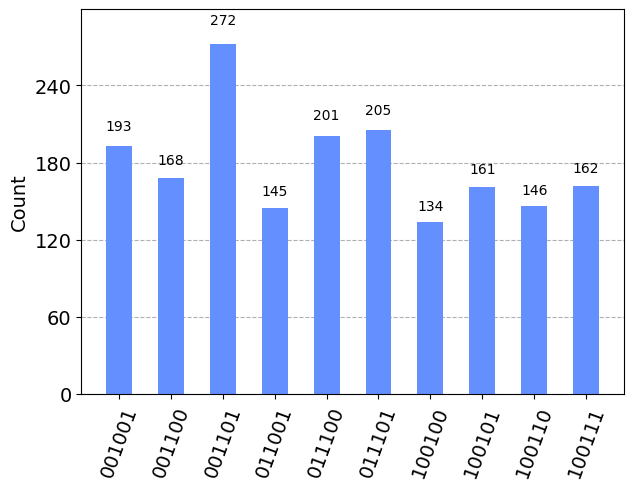

In [21]:
from qiskit.visualization import plot_histogram

qc_res = create_qaoa_circ(res.x)
tc = transpile(qc_res, backend, optimization_level=3,
                seed_transpiler=random_seed)
counts = backend.run(tc, seed_simulator=random_seed,
                     shots=shots).result().get_counts()


counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
counts_cost = dict(
    sorted(counts.items(), key=lambda item: item[1], reverse=True))

values = list(counts.values())
binary = list(counts.keys())

output = {}

print(len(counts))

for key in binary:
    if objective(key)[0] == 0:
        print("-----------------")
        print("BINGO")
        print(key)
        print(counts[key])
        print("-----------------")

for key in binary[:10]:
    print("Solution", key, "cost:", objective(key)[0], "count", counts[key])
    output[key] = counts[key]

# plot_histogram(output).savefig(f"./png/{H}_{M}_{N}_{shots}_{layers}_{time.time_ns()}.png")
plot_histogram(output)

In [22]:
sol = required_qubits
sol_bin = ""

for i in counts:
  ob = objective(i)[0]
  if ob < sol:
    sol = ob
    sol_bin = i

counts["H"] = H
counts["M"] = M
counts["N"] = N
counts["shots"] = shots
counts["layers"] = layers
counts["solution"] = sol_bin
counts["solution_cost"] = sol
counts["solution_count"] = counts[sol_bin]
counts["minimization_time"] = minimization_time
counts["execution_time"] = time.time() - simulation_time
counts["iterations"] = iterations 

print("Solution",sol_bin ,"cost:",sol,"count", counts[sol_bin])

Solution 011010 cost: 0 count 24


In [23]:
file = open(f"../json/{H}_{M}_{N}_{shots}_{layers}_quantum.json", "w")
file.write(json.dumps(counts))
file.flush()

In [24]:
counts["execution_time"]

In [25]:
minimization_time